# This assignment was completed by 

Bevan Fairleigh 219296864

Rao Siddhant Yadav 220384895

Chris Chong 220178171

### for Deakin University SIT789 T2 2021
### Applications of Computer Vision and Speech Processing
### 4.3P Image Recognition System

In [48]:
# PLEASE START BY LOOKING AT THE 4TH CELL

## Set up

import numpy as np
import cv2 as cv
import os
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier


## any imports go here


In [23]:
## Get dataset

## Assuming we can store up to 100MB on github, let's aim to keep dataset under 100MB
## test data set loaded now, stolen from simpsons data set, 
## Most of this code was for loading in and presplitting the dataset.  ignore it now, unless we need it for a different set.


# path = 'Dataset'
# subpaths = ["/test/","/train/","/validate/"]

# #Check files in dir

# classes = os.listdir(path+subpaths[1])
# # print(classes)

# import random 

# filenames = [os.path.join(path+"/classes/"+classes[3], f) for f in os.listdir(path+"/classes/"+classes[3])]

# random.shuffle(filenames)

# total = len(filenames)
# testsplit = .30 * total
# trainsplit = (.4 * total) + testsplit
# valsplit = (.3 * total) + trainsplit

# count = 0
# print (f"{testsplit} {trainsplit} {valsplit}")

# for fn in filenames:
#     if count < testsplit:
#         os.rename(fn, "Dataset/test/principal_skinner/"+str(count)+".jpg")
#     elif count < trainsplit:
#         os.rename(fn, "Dataset/train/principal_skinner/"+str(count)+".jpg")
#     else:
#         os.rename(fn, "Dataset/validate/principal_skinner/"+str(count)+".jpg")
    
    
#     count += 1





228.0 532.0 760.0


In [3]:
# path = 'C:/Users/admin/Desktop/Masters AI/Applications of CV and SP/Week 4/Updated/Submissions/computervisionproject-main/dataset'
# subpaths = ["/test/","/train/","/validate/"]
# classes =  os.listdir(path+subpaths[1])

# print(f"Our classes are {classes}")

# training_file_names = []
# test_file_names = []
# val_file_names = []

# training_labels = []
# test_labels = []
# val_labels = []

# for i in range(0,len(classes)):
#     sub_path = path + "/train/" + classes[i] + '/'
#     sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
#     sub_labels = [i] * len(sub_file_names)
#     training_file_names += sub_file_names
#     training_labels += sub_labels
    
#     sub_path = path + "/test/" + classes[i] + '/'
#     sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
#     sub_labels = [i] * len(sub_file_names)
#     test_file_names += sub_file_names
#     test_labels += sub_labels
    
#     sub_path = path + "/validate/" + classes[i] + '/'
#     sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
#     sub_labels = [i] * len(sub_file_names)
#     val_file_names += sub_file_names
#     val_labels += sub_labels
    
# print(training_labels)
# print(test_labels)
# print(val_labels)







In [49]:
# Starting here from 4.1
# 1. Bag-of-Words (BoW) model

import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
 
    def learn(self):
        sift = cv.xfeatures2d.SIFT_create()
        
        num_keypoints = [] #this is used to store the number of keypoints in each image
 
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
 
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words) #num_words is number of clusters
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
 
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
 
        return training_word_histograms
 
    def create_word_histograms(self, img_filenames):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []
        
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
 
                    histogram[matching_word_ID] += 1
 
                histogram /= len(descriptors) #normalise histogram to frequencies
 
            histograms.append(histogram)
    
        return histograms


In [50]:
# Creating list of file names and labels of all training images
class_labels = ['chief_wiggum', 'comic_book_guy', 'mayor_quimby','principal_skinner']
path = 'dataset/'
training_file_names = []
training_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'train/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_labels += sub_labels

# Creating list of file names and labels of all validation images
validate_file_names = []
validate_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'validate/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    validate_file_names += sub_file_names
    validate_labels += sub_labels
    
# Creating list of file names and labels of all test images
test_file_names = []
test_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'test/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    test_file_names += sub_file_names
    test_labels += sub_labels

In [51]:
print(training_file_names)
print(training_labels)
print(validate_file_names)
print(validate_labels)
print(test_file_names)
print(test_labels)

['dataset/train/chief_wiggum/a_0.jpg', 'dataset/train/chief_wiggum/a_1.jpg', 'dataset/train/chief_wiggum/a_10.jpg', 'dataset/train/chief_wiggum/a_11.jpg', 'dataset/train/chief_wiggum/a_12.jpg', 'dataset/train/chief_wiggum/a_13.jpg', 'dataset/train/chief_wiggum/a_14.jpg', 'dataset/train/chief_wiggum/a_15.jpg', 'dataset/train/chief_wiggum/a_16.jpg', 'dataset/train/chief_wiggum/a_17.jpg', 'dataset/train/chief_wiggum/a_18.jpg', 'dataset/train/chief_wiggum/a_19.jpg', 'dataset/train/chief_wiggum/a_2.jpg', 'dataset/train/chief_wiggum/a_20.jpg', 'dataset/train/chief_wiggum/a_21.jpg', 'dataset/train/chief_wiggum/a_22.jpg', 'dataset/train/chief_wiggum/a_23.jpg', 'dataset/train/chief_wiggum/a_24.jpg', 'dataset/train/chief_wiggum/a_25.jpg', 'dataset/train/chief_wiggum/a_26.jpg', 'dataset/train/chief_wiggum/a_27.jpg', 'dataset/train/chief_wiggum/a_28.jpg', 'dataset/train/chief_wiggum/a_29.jpg', 'dataset/train/chief_wiggum/a_3.jpg', 'dataset/train/chief_wiggum/a_30.jpg', 'dataset/train/chief_wiggum/

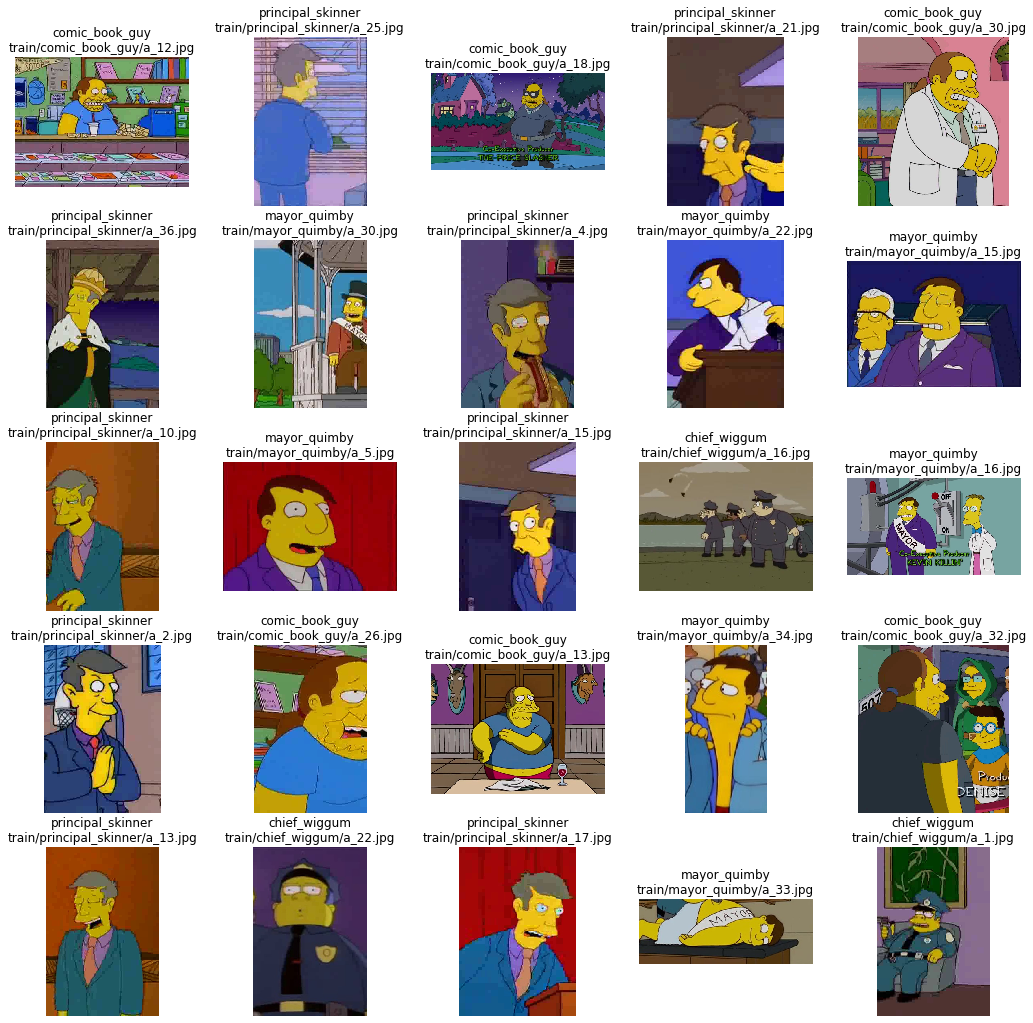

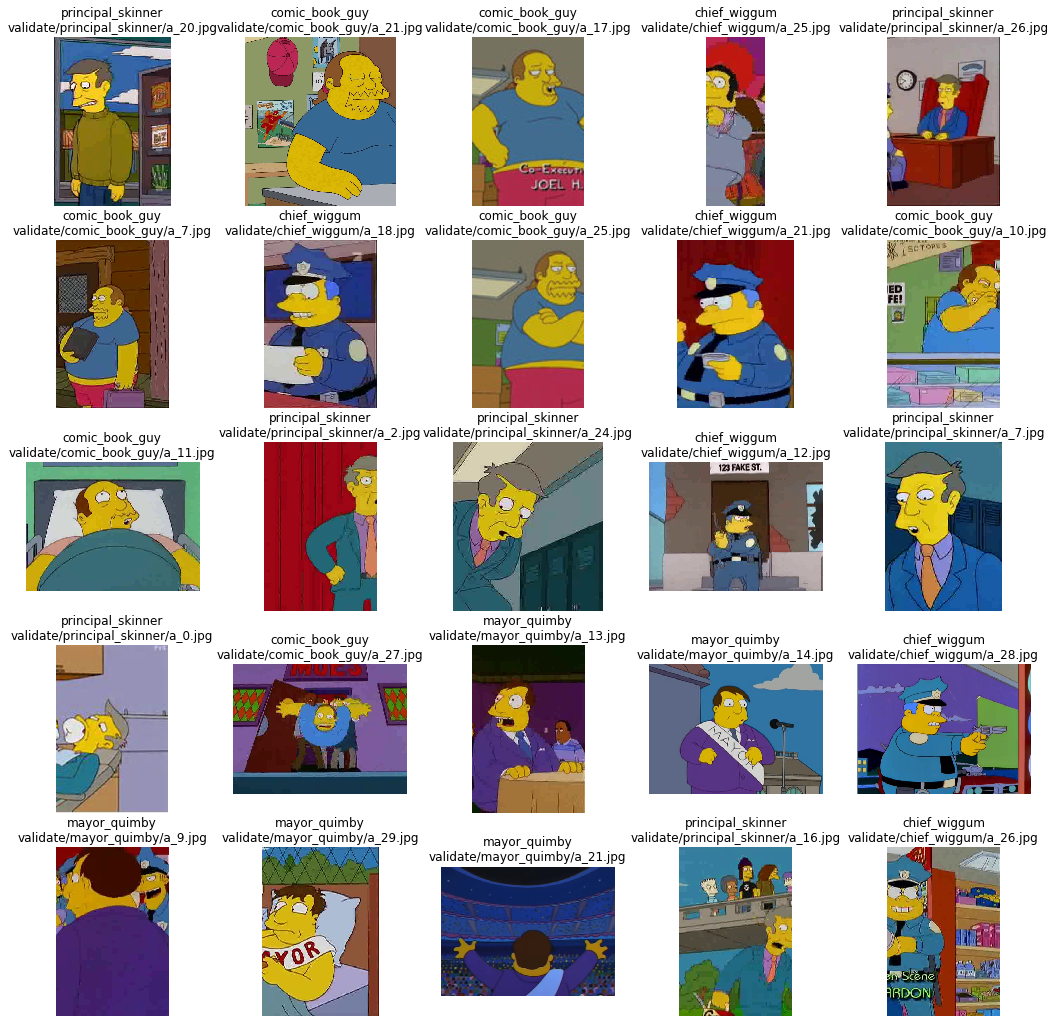

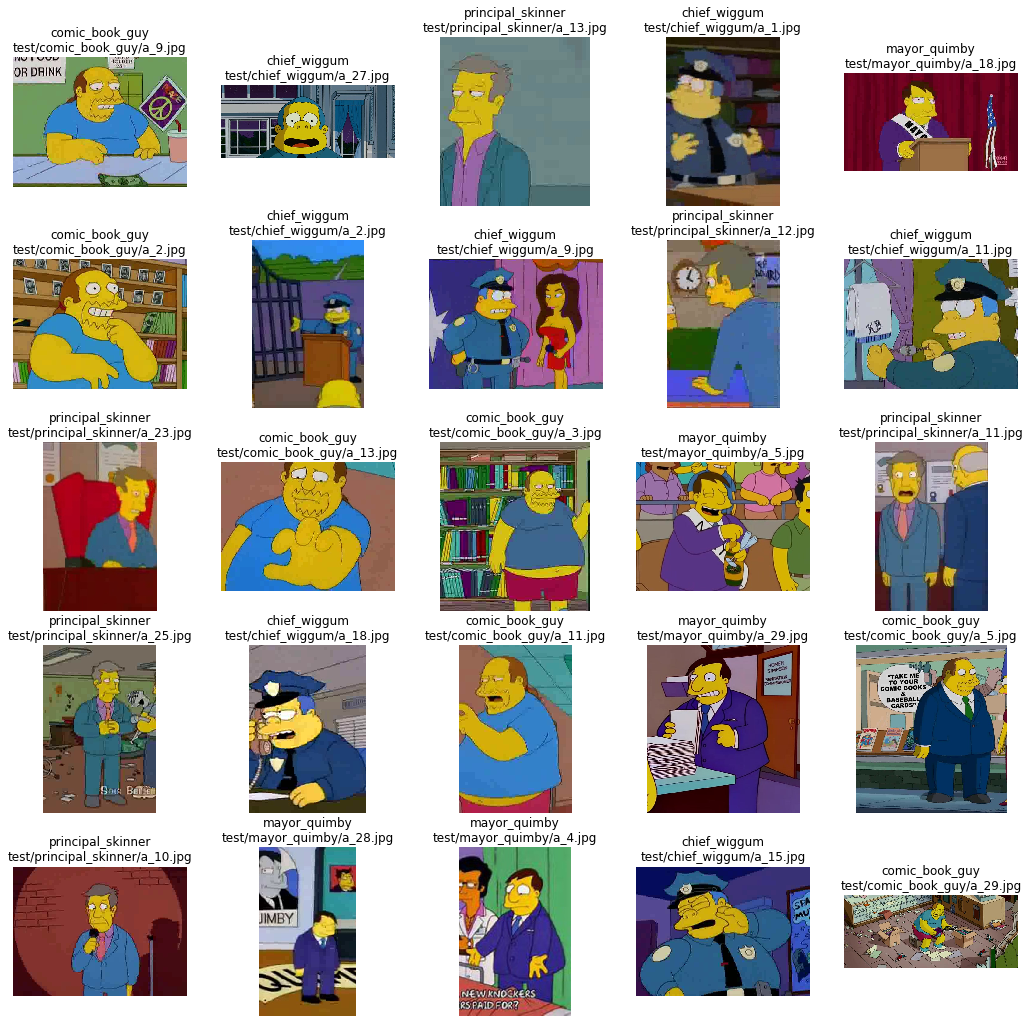

In [52]:
# Sample of Training Images
num_rows = np.shape(training_file_names)[0]
images = []
image_class = []

index_value = random.sample(list(enumerate(training_file_names)), 25)
for idx, val in index_value:
    image_class.append(training_labels[idx])
    images.append(val)

f, axarr = plt.subplots(5,5, figsize=(18,18))
counter = 0
for i in range(5):
  for j in range(5):
    image = cv.imread(images[counter])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    axarr[i,j].imshow(image)
    axarr[i,j].axis('off')
    title = (class_labels[image_class[counter]]+'\n'+images[counter][8:])
    axarr[i,j].set_title(title)
    counter = counter+1
plt.show()
print('\n\n\n')

# Sample of Validation Images
num_rows2 = np.shape(validate_file_names)[0]
images2 = []
image_class2 = []

index_value = random.sample(list(enumerate(validate_file_names)), 25)
for idx, val in index_value:
    image_class2.append(validate_labels[idx])
    images2.append(val)

f, axarr2 = plt.subplots(5,5, figsize=(18,18))
counter = 0
for i in range(5):
  for j in range(5):
    image = cv.imread(images2[counter])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    axarr2[i,j].imshow(image)
    axarr2[i,j].axis('off')
    title = (class_labels[image_class2[counter]]+'\n'+images2[counter][8:])
    axarr2[i,j].set_title(title)
    counter = counter+1
plt.show()
print('\n\n\n')

# Sample of Test Images
num_rows3 = np.shape(test_file_names)[0]
images3 = []
image_class3 = []

index_value = random.sample(list(enumerate(test_file_names)), 25)
for idx, val in index_value:
    image_class3.append(test_labels[idx])
    images3.append(val)

f, axarr2 = plt.subplots(5,5, figsize=(18,18))
counter = 0
for i in range(5):
  for j in range(5):
    image = cv.imread(images3[counter])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    axarr2[i,j].imshow(image)
    axarr2[i,j].axis('off')
    title = (class_labels[image_class3[counter]]+'\n'+images3[counter][8:])
    axarr2[i,j].set_title(title)
    counter = counter+1
plt.show()

## 2. Building and Image Recognition System
### 2.1 Building BoW Model

In [53]:
# Building an Image Recognition System


sift = cv.xfeatures2d.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
 
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)



In [ ]:
# Elbow method to Determine K
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(10, 100)

# timer
start_time = time.time()
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(training_data)
    kmeanModel.fit(training_data)
 
    distortions.append(sum(np.min(cdist(training_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / np.concatenate( training_data, axis=0 ).shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(training_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / np.concatenate( training_data, axis=0 ).shape[0]
    mapping2[k] = kmeanModel.inertia_
# end time
end_time = time.time()
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

print('run time =',(end_time-start_time)/60,'minutes')

In [33]:
# NOTE: ONCE WE GET THE BEST K FROM HERE, WE CAN SIMPLY RUN 4.1 FOR THAT K VALUE BY REPLACING num_words

# BoW model and creating dictionary.

num_words = 5 # We change this after we find best K
dictionary_name = 'dictionary'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

# Learning the dictionary
training_word_histograms = dictionary.learn()

# Save the dictionary into file once the training is complete and reloading it for use without retraining
import pickle
#save dictionary
with open('dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)
    

# we now have a built dictionary

In [ ]:
# Optional load of the dictionary
import pickle #you may not need to import it if this has been done
with open('dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

## 2.1. Building Classifiers
### Preprocessing

In [54]:
# build the validation set file names and corresponding labels

# array to store the image paths
validate_file_names = []
# array for true labels based on the folder name
validate_labels = []

for subdir, dirs, files in os.walk('dataset/validate/'):
    for file in files:
        filepath = subdir+'/'+file
        validate_file_names.append(filepath)
        for i in class_labels:
            if subdir == ('dataset/validate/'+i):
                validate_labels.append(class_labels.index(i))

# extract the word histogram for the images
word_histograms = dictionary.create_word_histograms(validate_file_names)

### 2.1.1 k-NN Classifier

In [55]:
# iterate through different numbers of nearest neighbours
num_nearest_neighbours = [5, 10, 15, 20, 25, 30]

for n in num_nearest_neighbours:
    knn = KNeighborsClassifier(n_neighbors = n)
    # Train on TRAINING set
    knn.fit(training_word_histograms, training_labels)
    predicted_labels = knn.predict(word_histograms)
    print(n,'nearest neighbours:')
    print(' Accuracy :~',100*np.round(accuracy_score(validate_labels, predicted_labels),5),'%')
    # Tune on VALIDATION set
    cm = confusion_matrix(validate_labels, predicted_labels)
    print(' Confusion Matrix')
    print('',cm,'\n')

5 nearest neighbours:
 Accuracy :~ 33.333 %
 Confusion Matrix
 [[19  5  2  4]
 [15 10  4  1]
 [12  8  8  2]
 [12  7  8  3]] 

10 nearest neighbours:
 Accuracy :~ 34.166999999999994 %
 Confusion Matrix
 [[14  7  4  5]
 [10 10  7  3]
 [11  5  7  7]
 [11  6  3 10]] 

15 nearest neighbours:
 Accuracy :~ 35.0 %
 Confusion Matrix
 [[16  7  3  4]
 [ 7 11  6  6]
 [16  5  5  4]
 [ 9  4  7 10]] 

20 nearest neighbours:
 Accuracy :~ 37.5 %
 Confusion Matrix
 [[17  5  1  7]
 [ 5 12  3 10]
 [14  5  6  5]
 [ 9  3  8 10]] 

25 nearest neighbours:
 Accuracy :~ 39.167 %
 Confusion Matrix
 [[18  3  1  8]
 [ 5 13  3  9]
 [16  6  3  5]
 [10  2  5 13]] 

30 nearest neighbours:
 Accuracy :~ 37.5 %
 Confusion Matrix
 [[19  3  2  6]
 [ 5 13  3  9]
 [14  7  2  7]
 [ 7  6  6 11]] 



### 2.1.2 Linear SVM Classifier

In [56]:
# iterate through different C values
C = [0.1, 1, 10, 100]

for i in C:
    svm_classifier = svm.SVC(C = i, kernel = 'linear')
    # Train on TRAINING set
    svm_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = svm_classifier.predict(word_histograms)
    print('C value =', i,':')
    print(' Accuracy :~',100*np.round(accuracy_score(validate_labels, predicted_labels),5),'%')
    # Tune on VALIDATION set
    cm = confusion_matrix(validate_labels, predicted_labels)
    print(' Confusion Matrix')
    print('',cm,'\n')

C value = 0.1 :
 Accuracy :~ 35.0 %
 Confusion Matrix
 [[ 7  4  7 12]
 [ 0 10  5 15]
 [ 7  8  4 11]
 [ 4  3  2 21]] 

C value = 1 :
 Accuracy :~ 35.0 %
 Confusion Matrix
 [[ 7  4  7 12]
 [ 0 10  5 15]
 [ 7  8  4 11]
 [ 4  3  2 21]] 

C value = 10 :
 Accuracy :~ 37.5 %
 Confusion Matrix
 [[ 6  5 10  9]
 [ 2 12  4 12]
 [ 7  5  9  9]
 [ 5  4  3 18]] 

C value = 100 :
 Accuracy :~ 37.5 %
 Confusion Matrix
 [[10  6  7  7]
 [ 3 11  2 14]
 [11  7  4  8]
 [ 5  2  3 20]] 



### 2.1.3 AdaBoost Classifier

In [57]:
# iterate through different n_estimators
n_estimators = [50, 100, 150, 200, 250]

for i in n_estimators:
    adb_classifier = AdaBoostClassifier(n_estimators = i, #weak classifiers
                                        random_state = 0)
    # Train on TRAINING set
    adb_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = adb_classifier.predict(word_histograms)
    print('Number of estimators =', i,':')
    print(' Accuracy :~',100*np.round(accuracy_score(validate_labels, predicted_labels),5),'%')
    # Tune on VALIDATION set
    cm = confusion_matrix(validate_labels, predicted_labels)
    print(' Confusion Matrix')
    print('',cm,'\n')

Number of estimators = 50 :
 Accuracy :~ 34.166999999999994 %
 Confusion Matrix
 [[16  3  7  4]
 [10 10  8  2]
 [10  3  9  8]
 [11  3 10  6]] 

Number of estimators = 100 :
 Accuracy :~ 36.667 %
 Confusion Matrix
 [[12  6  8  4]
 [ 7 12  9  2]
 [ 9  3 14  4]
 [10  6  8  6]] 

Number of estimators = 150 :
 Accuracy :~ 37.5 %
 Confusion Matrix
 [[14  5  7  4]
 [ 7 13  9  1]
 [10  4 11  5]
 [ 7  6 10  7]] 

Number of estimators = 200 :
 Accuracy :~ 35.833 %
 Confusion Matrix
 [[14  5  8  3]
 [10 11  8  1]
 [12  3 11  4]
 [ 7  4 12  7]] 

Number of estimators = 250 :
 Accuracy :~ 35.0 %
 Confusion Matrix
 [[14  6  7  3]
 [ 9 10  9  2]
 [10  3 12  5]
 [ 8  4 12  6]] 



## 2.2 Evaluating Classifiers
### 2.2.1 Comparison and Conclusions

In [58]:
# build the test set file names and corresponding labels

# array to store the image paths
test_file_names = []
# array for true labels based on the folder name
test_labels = []

for subdir, dirs, files in os.walk('dataset/test/'):
    for file in files:
        filepath = subdir+'/'+file
        test_file_names.append(filepath)
        for i in class_labels:
            if subdir == ('dataset/test/'+i):
                test_labels.append(class_labels.index(i))

# extract the word histogram for the images
test_word_histograms = dictionary.create_word_histograms(test_file_names)

In [59]:
# Evaluate all the three tuned models on the TEST set

test_Y=test_labels

# k-NN

knn = KNeighborsClassifier(n_neighbors = i) # change i to best value and delete this comment
knn.fit(training_word_histograms, training_labels)
pred_y_knn = knn.predict(word_histograms) 


# SVM

svm_classifier = svm.SVC(C = i, kernel = 'linear') # change i to best value and delete this comment
svm_classifier.fit(training_word_histograms, training_labels)
pred_y_svm = svm_classifier.predict(test_word_histograms)


# AdaBoost

adb_classifier = AdaBoostClassifier(n_estimators = i, #weak classifiers # change i to best value and delete this comment
                                    random_state = 0)
adb_classifier.fit(training_word_histograms, training_labels)
pred_y_ada = adb_classifier.predict(test_word_histograms)


# Recognition Accuracy
acc = accuracy_score(test_Y, pred_y_knn)
acc2 = accuracy_score(test_Y, pred_y_svm)
acc3 = accuracy_score(test_Y, pred_y_ada)
print('Recognition accuracy for k-NN Classifier:',acc)
print('Recognition accuracy for Linear SVM Classifier:',acc2)
print('Recognition accuracy for AdaBoost Classifier:',acc3)

# Confusion Matrices
fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(knn, test_x,  pred_y_knn, values_format ="",cmap="Blues", ax=ax)
ax.set_title('k-NN Classifier Confusion Matrix')

fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(svm_classifier, test_x,  pred_y_svm, values_format ="",cmap="Blues", ax=ax)
ax.set_title('Linear SVM Classifier Confusion Matrix')
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(adb_classifier, test_x,  pred_y_ada, values_format ="",cmap="Blues", ax=ax)
ax.set_title('AdaBoost Classifier Confusion Matrix')
plt.show()

TypeError: '<' not supported between instances of 'str' and 'int'

| Classifier   | Tuned Hyperparameter Value  | Recognition Accuracy (%)|
|---|---|---|
| k-NN  | num_nearest_neighbours =   | 80.00%  |
| Linear SVM  | C =   | 80.00%  |
| AdaBoost  | n_estimators =   | 80.00%  |

